# IMU noise characterization

Three different approaches;
- historgram
- custom Allan deviation
- using allan tools

Familiarity with the IEEE Standard 952 as well as with the nomenclature commonly used, the various units, etc, is helpful.

References

- mixture of gaussian:
https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of

Few notes:
Histogram
This method uses numpy.histogram to bin the data in x and count the number of values in each bin, then draws the distribution either as a BarContainer or Polygon. The bins, range, density, and weights parameters are forwarded to numpy.histogram.
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist

In [46]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

HOME = os.getenv("HOME")
#CSV_FILENAME = 'imu_oakdpro_1hr_28032024.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_level.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_xUp.csv'

CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yDown.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_yUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zUp.csv'
# CSV_FILENAME = 'oak_BNO086_6mn_gyroSR400_accSR500_zDown.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR100_accSR125.csv' 
# CSV_FILENAME = HOME+'/Data/Drones/IMU/imu_oak_BNO086_2hr_02042024.csv'
FS = 100  # Sample rate [Hz] # this is obtained from the measured data
NOISE_PARAM_UNIT = 'rad'
PRECI= 2
TYPE = "e" # e: exponential notation
TS = 1.0 / FS
NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 30 # number of bins for the histogram

The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [2]:
N = 5e-3 # °/sqrt(s) = 0.3 °/sqrt(h)
B = 7e-4 # °/s = 2.5 °/h
K = 6e-6 # °/s/sqrt(s)

Define the sampling rate ``fs`` and initialize noise sources:

In [2]:
# functions
# for FHWM
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

In [51]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [52]:
# Separate into arrays and select a slice of the input data
acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
accx = dataArr[:NB_SAMPLE, 1]  # m/s²
accy = dataArr[:NB_SAMPLE, 2]
accz = dataArr[:NB_SAMPLE, 3]
ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
gy = dataArr[:NB_SAMPLE, 6]
gz = dataArr[:NB_SAMPLE, 7]

In [5]:
# Rerun and compare with data at the end of the data gathering (2hrs after start)
acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
accy = dataArr[-NB_SAMPLE:, 2]
accz = dataArr[-NB_SAMPLE:, 3]
ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
gy = dataArr[-NB_SAMPLE:, 6]
gz = dataArr[-NB_SAMPLE:, 7]

In [5]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'total number of samples: {tot_nb_sample}')

total number of samples: 36000


In [15]:
NBINS = 200
acc_ts_grad=np.gradient(acc_ts[1:]) # remove the first sample which is off
gyro_ts_grad=np.gradient(ts)
print(len(acc_ts_grad))
# idx_high_ts = np.where(acc_ts_grad < 1.0)
# print(idx_high_ts)
# print(f'{acc_ts_grad}')
# plt.hist(acc_ts_grad,NBINS)

999


Note:

In some data samples, the accelerometer time stamp has an 'outlier' at the last bin.

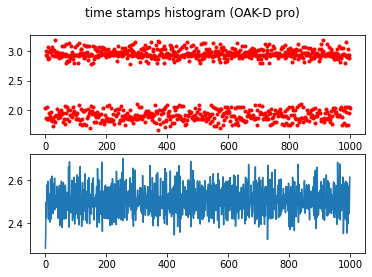

In [19]:
# idx_non0bin_ts = np.where(acc_ts_grad > 12.0)
# print(idx_high_ts)
f, axarr = plt.subplots(2, sharex=False)
# f.set_figheight(12)
# f.set_figwidth(8)
f.suptitle(f'time stamps histogram (OAK-D pro)',fontsize = 12)
axarr[0].plot(acc_ts_grad, 'r.',label='accel time stamp') # alpha=0.1 is the opacity (alpha in 0 - 1 range)
axarr[1].plot(gyro_ts_grad, label='accel time stamp') # alpha=0.1 is the opacity (alpha in 0 - 1 range)

[  1   2   3   6  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 197 198]
1 199
acc_cnt [ 1.  0.  0.  0.  2.  1.  0.  1.  3.  6.  5.  8.  6.  2.  6.  6.  8.  7.
  8.  5.  8.  7.  7. 28. 19. 17. 12.  8.  9. 13. 17. 14. 16.  9.  6. 10.
 18. 16.  3.  7.  9.  5. 10.  9. 11. 11.  4.  8.  2.  9. 12.  6.  3.  5.
  5.  3.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  6

/home/ludovic/.virtualenvs/IMU/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


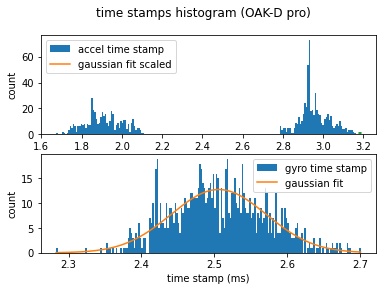

In [29]:
f, axarr = plt.subplots(2, sharex=False)
# f.set_figheight(12)
# f.set_figwidth(8)
f.suptitle(f'time stamps histogram (OAK-D pro)',fontsize = 12)
acc_cnt, bins_acc_ts, b = axarr[0].hist(acc_ts_grad, NBINS , density=False, label='accel time stamp') # alpha=0.1 is the opacity (alpha in 0 - 1 range)
gyr_cnt, bins_gyro_ts, _ = axarr[1].hist(gyro_ts_grad, NBINS, density=False, label='gyro time stamp') #, density=1, alpha=0.5,label='gyro time stamp')

# split the time stamp histo of the slowest sensor (the one with the smallest sampling rate)
idx_bin_0_ts = np.where(acc_cnt == 0.0)[0]
print(idx_bin_0_ts)
idx_low_bins_ts = idx_bin_0_ts[0] # end index for which the histo count is not zero (lower ts)
idx_hi_bins_ts = idx_bin_0_ts[-1]+1 # start index from which the histo count is not zero (higher ts)
# print(idx_bin_0_ts,idx_low_bins_ts,idx_hi_bins_ts)
print(idx_low_bins_ts,idx_hi_bins_ts)

bins_acc_low_ts = bins_acc_ts[:idx_low_bins_ts]
bins_acc_hi_ts = bins_acc_ts[idx_hi_bins_ts:]

cnt_acc_low_ts = acc_cnt[:idx_low_bins_ts]
cnt_acc_hi_ts = acc_cnt[idx_hi_bins_ts:]
# print(idx_hi_bins_ts)
# print(bins_acc_low_ts, bins_acc_hi_ts, acc_cnt[idx_hi_bins_ts])
# pouet

with np.printoptions(precision=3, suppress=True):
    print(f'acc_cnt {acc_cnt}\n,bins_acc_ts {bins_acc_ts}\n b {b}')
    print(f'gyr_cnt = {gyr_cnt},\nbins_gyro_ts {bins_gyro_ts}')
'''
# axarr[0].set_title('Gyro Angular rate X')
accel_expectd_fit=(1.7,.06,100,3,0.06,200)
# Create an array of length num_bins containing the center of each bin.

centers = 0.5*(bins_acc_ts[:-1] + bins_acc_ts[1:])
acc_params,acc_cov=curve_fit(bimodal,acc_cnt,centers,accel_expectd_fit)

# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(gyro_ts_grad)),gyro_ts_grad,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(acc_ts_grad)),acc_ts_grad,expected)
acc_sigma=np.sqrt(np.diag(acc_cov))
print(f'acc_params {acc_params} ,{acc_sigma}')  

gyro_expectd_fit=(2.5,.06,70)
# Create an array of length num_bins containing the center of each bin.
gyro_bin_centers = 0.5*(bins_gyro_ts[:-1] + bins_gyro_ts[1:])
gyr_params,gyr_cov=curve_fit(gauss,gyr_cnt,gyro_bin_centers,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(gyro_ts_grad)),gyro_ts_grad,gyro_expectd_fit)
# gyr_params,gyr_cov=curve_fit(gauss,np.arange(len(acc_ts_grad)),acc_ts_grad,expected)
gyr_sigma=np.sqrt(np.diag(gyr_cov))
print(f'gyr_params {gyr_params} ,{gyr_sigma}')  
# params,cov=curve_fit(bimodal,bins_acc_ts,expected)
# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
'''
'''
# yet another way for the fit
from scipy.optimize import leastsq
# fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)+p[3]
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))
init  = [1.0, 0.5, 0.5]
# init  = [1.0, 0.5, 0.5, 0.5]
out   = leastsq( errfunc, init, args=(gyr_cnt,gyro_bin_centers))
c = out[0]
print("Fit Coefficients:")
print(c[0],c[1],abs(c[2]))
# print(c[0],c[1],abs(c[2]),c[3])
'''

mu, sigma = zip(stats.norm.fit(bins_acc_low_ts),stats.norm.fit(bins_acc_hi_ts),stats.norm.fit(gyro_ts_grad))
mu_lowts, sigma_lowts = stats.norm.fit(acc_ts_grad)


print(f'Gaussian best fit mu, sigma = {mu,sigma}\nlower FS ts: {mu_lowts,sigma_lowts})')
# gauss_fit_accts = stats.norm.pdf(bins_acc_ts, mu[0], sigma[0])
gauss_fit_accts_low_ts = stats.norm.pdf(bins_acc_low_ts, mu[0], sigma[0])
gauss_fit_accts_hi_ts = stats.norm.pdf(bins_acc_hi_ts, mu[1], sigma[1])
gauss_fit_gyrots =  stats.norm.pdf(bins_gyro_ts, mu[2], sigma[2])
# gauss_fit_gyrots = 1/sigma[1]* stats.norm.pdf(bins_gyro_ts, mu[1], sigma[1])
# axarr[0].plot(bins_acc_low_ts,gauss_fit_accts_low_ts,label = 'gaussian fit')
axarr[0].plot(bins_acc_low_ts,sum(cnt_acc_low_ts)*gauss_fit_accts_low_ts/sum(gauss_fit_accts_low_ts),label = 'gaussian fit scaled')
axarr[0].plot(bins_acc_hi_ts,sum(cnt_acc_hi_ts)*gauss_fit_accts_hi_ts/sum(gauss_fit_accts_hi_ts))
# axarr[0].plot(bins_acc_ts,gauss_fit_accts,label = 'gaussian fit')
# axarr[0].plot(bins_acc_ts,bimodal(bins_acc_ts,*acc_params),'r+',label = 'bimodal fit')

# axarr[1].plot(bins_gyro_ts,1/sigma[1]*gauss_fit_gyrots,label = 'gaussian fit')
axarr[1].plot(bins_gyro_ts,sum(gyr_cnt)*gauss_fit_gyrots/sum(gauss_fit_gyrots),label = 'gaussian fit')
# axarr[1].plot(bins_gyro_ts, fitfunc(c, bins_gyro_ts))
# axarr[1].plot(bins_gyro_ts,gauss(bins_gyro_ts,*gyr_params),label = 'curve fit')
with np.printoptions(precision=3, suppress=True):
    print(f'gauss_fit_accts_low \n{gauss_fit_accts_low_ts}')
    # print(f'gauss_fit_accts \n{gauss_fit_accts}')
for i in range(2):
    # axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('time stamp (ms)')
    axarr[i].legend()
# print(dataArr.shape)
# f.savefig('test.png', bbox_inches='tight')

In [31]:
# average sampling time period (ts is in ms)
fs_actual = 1000 / mu[2]
print(f'average sampling period = {mu[2]:.2}ms \n'
      f'actual sampling frequency = {fs_actual}')

average sampling period = 2.5ms 
actual sampling frequency = 399.0169021564669


(array([ 1.,  0.,  0.,  0.,  1.,  5.,  1., 10., 13., 16., 47., 42., 55.,
       60., 90., 69., 71., 69., 74., 70., 66., 58., 58., 50., 22., 18.,
       17.,  8.,  3.,  6.]), array([2.276     , 2.28926667, 2.30253333, 2.3158    , 2.32906667,
       2.34233333, 2.3556    , 2.36886667, 2.38213333, 2.3954    ,
       2.40866667, 2.42193333, 2.4352    , 2.44846667, 2.46173333,
       2.475     , 2.48826667, 2.50153333, 2.5148    , 2.52806667,
       2.54133333, 2.5546    , 2.56786667, 2.58113333, 2.5944    ,
       2.60766667, 2.62093333, 2.6342    , 2.64746667, 2.66073333,
       2.674     ]), <BarContainer object of 30 artists>)


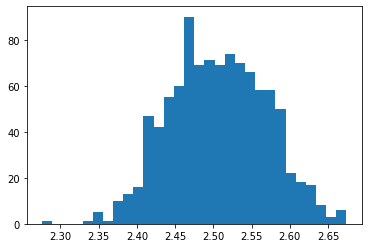

In [61]:
gyro_ts_grad=np.gradient(ts)
# print(f'{np.gradient(acc_ts)}')
a=plt.hist(gyro_ts_grad,NBINS)
print(a)
# print(dataArr.shape)

In [16]:
print(f'average sampling period accelerometer: {np.average(acc_ts_grad):.3}ms')
print(f'average sampling period gyroscope: {np.average(gyro_ts_grad):.3}ms')

average sampling period accelerometer: 2.5ms
average sampling period gyroscope: 2.51ms


In [17]:
# print(f'{acc_ts,ts}')

Now create an artifical sensor noise signal $w_{noise}$ from the individual noise sources denoted by $\xi$. The noise is additive and the coefficients $N$, $B$ and $K$ from the IEEE Std 952 enter as follows:

$$w_{noise} = N\xi_{white} + \frac{B}{\sqrt{2\pi}}\xi_{pink} + \frac{K}{2\pi}\xi_{red}$$

bins_gx:
[-0.015 -0.014 -0.013 -0.011 -0.01  -0.009 -0.008 -0.007 -0.006 -0.004
 -0.003 -0.002 -0.001  0.     0.001  0.003  0.004  0.005  0.006  0.007
  0.009  0.01   0.011  0.012  0.013  0.014  0.016  0.017  0.018  0.019
  0.02 ]
Gaussian best fit mu, sigma = ((0.001319864, -0.0017023, 0.001888723), (0.005755801140024211, 0.0048549220296519695, 0.005922681675919363))
gauss_fit_gx: 
[ 1.298  2.258  3.769  6.033  9.267 13.655 19.304 26.184 34.072 42.537
 50.949 58.547 64.547 68.272 69.281 67.45  63.001 56.457 48.538 40.036
 31.682 24.054 17.521 12.244  8.209  5.28   3.258  1.929  1.096  0.597
  0.312]


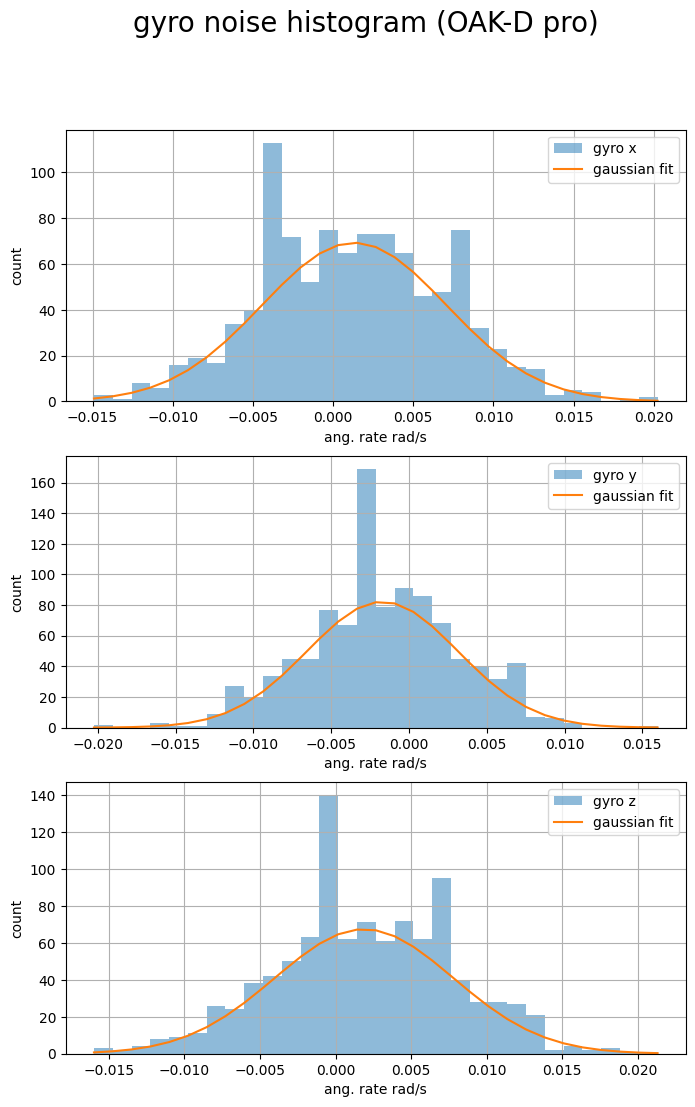

In [11]:
f, axarr = plt.subplots(3, sharex=False)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'gyro noise histogram (OAK-D pro)',fontsize = 20)
histo_density = False
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
# _, bins_gx, _ = axarr[0].hist(acc_ts_grad, NBINS, density=histo_density, alpha=0.5,label='gyro x')
_, bins_gx, _ = axarr[0].hist(gx, NBINS, density=histo_density, alpha=0.5,label='gyro x')
_, bins_gy, _ = axarr[1].hist(gy, NBINS, density=histo_density, alpha=0.5,label='gyro y')
_, bins_gz, _ = axarr[2].hist(gz, NBINS, density=histo_density, alpha=0.5,label='gyro z')
np.set_printoptions()  # formatter gets reset
# reset the default print options
np.set_printoptions(edgeitems=3, infstr='inf',
                    linewidth=75, nanstr='nan', precision=8,
                    suppress=False, threshold=1000, formatter=None)
with np.printoptions(precision=3):
    print(f'bins_gx:\n{bins_gx}')
for i in range(3):
    axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('ang. rate rad/s')

# axarr[0].set_title('Gyro Angular rate X')

# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(gx),stats.norm.fit(gy),stats.norm.fit(gz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
gauss_fit_gx = stats.norm.pdf(bins_gx, mu[0], sigma[0])
gauss_fit_gy = stats.norm.pdf(bins_gy, mu[1], sigma[1])
gauss_fit_gz = stats.norm.pdf(bins_gz, mu[2], sigma[2])
axarr[0].plot(bins_gx,gauss_fit_gx,label = 'gaussian fit')
axarr[1].plot(bins_gy,gauss_fit_gy,label = 'gaussian fit')
axarr[2].plot(bins_gz,gauss_fit_gz,label = 'gaussian fit')

hmx = half_max_x(bins_gx,gauss_fit_gx)

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()
# plt.plot(gauss_fit_gx)
# np.set_printoptions(precision=2)
with np.printoptions(precision=3, suppress=True):
    print(f'gauss_fit_gx: \n{gauss_fit_gx}')
# np.set_printoptions()  # formatter gets reset
#axarr[0].set_ylim([-2, 2])

## same for the acceleration

Gaussian best fit mu, sigma = ((0.7313137609999999, -10.112216956000001, 0.08569321299999999), (0.028320856924568486, 0.0228167935492711, 0.026407144631285507))
Magnitude of gravity vector: 10.14


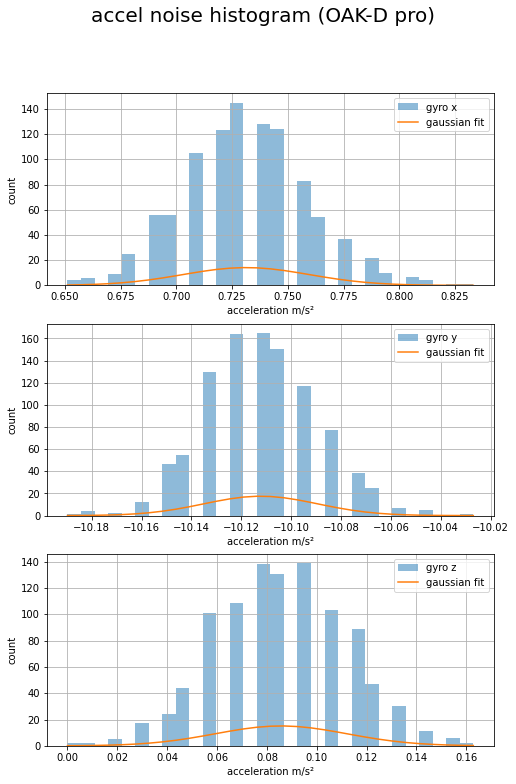

In [53]:
histo_density = False # True: draw and return a probability density, i.e. area under the histogram = 1,
                        # use False to get the real count plot
f, axarr = plt.subplots(3, sharex=False)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'accel noise histogram (OAK-D pro)',fontsize = 20)
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
_, bins_accx, _ = axarr[0].hist(accx, NBINS, density=histo_density, alpha=0.5,label='gyro x')
_, bins_accy, _ = axarr[1].hist(accy, NBINS, density=histo_density, alpha=0.5,label='gyro y')
_, bins_accz, _ = axarr[2].hist(accz, NBINS, density=histo_density, alpha=0.5,label='gyro z')
for i in range(3):
    axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('acceleration m/s²')
    
# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(accx),stats.norm.fit(accy),stats.norm.fit(accz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
g_eval = np.linalg.norm(mu)
print(f'Magnitude of gravity vector: {g_eval:.4}')
gauss_fit_accx = stats.norm.pdf(bins_accx, mu[0], sigma[0])
gauss_fit_accy = stats.norm.pdf(bins_accy, mu[1], sigma[1])
gauss_fit_accz = stats.norm.pdf(bins_accz, mu[2], sigma[2])
axarr[0].plot(bins_accx,gauss_fit_accx,label = 'gaussian fit')
axarr[1].plot(bins_accy,gauss_fit_accy,label = 'gaussian fit')
axarr[2].plot(bins_accz,gauss_fit_accz,label = 'gaussian fit')

# hmx = half_max_x(bins_accx,gauss_fit_accx)

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()
#axarr[0].set_ylim([-2, 2])

0.7313137609999999
-10.112216956000001
(731.313761+0j) (-10112.216956+0j) (85.693213+0j)


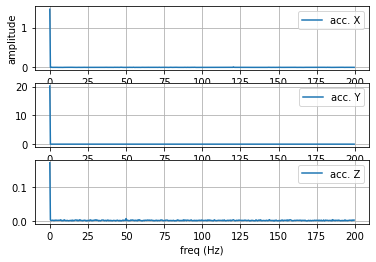

In [57]:
N = len(gx)  # Number of elements
print(N)
REMOVE_DC = False
if REMOVE_DC:
    idx_0 = 1
    accx_dc = accx - np.average(accx)
    accy_dc = accy - np.average(accy)
    accz_dc = accz - np.average(accz)
else:
    idx_0 = 0
    accx_dc = accx
    accy_dc = accy
    accz_dc = accz

idx_0= 0
print(np.average(accx))

print(np.average(accy))
# Compute FFTs
freqBins = np.linspace(0, fs_actual / 2, N // 2)  # Freq. labels [Hz]
# FFT of accelerometer data
fax = np.fft.fft(accx_dc)  
fay = np.fft.fft(accy_dc)
faz = np.fft.fft(accz_dc)
print(fax[0],fay[0],faz[0])
# fgx = np.fft.fft(gx)  # FFT of gyro data

# Plot x-accel. FFT
fig, axacc = plt.subplots(3,sharex = False) 
axacc[0].plot(freqBins[idx_0:], (2 / N) * np.abs(fax[idx_0:N // 2]),label = 'acc. X')
axacc[1].plot(freqBins[idx_0:], (2 / N) * np.abs(fay[idx_0:N // 2]),label = 'acc. Y')
axacc[2].plot(freqBins[idx_0:], (2 / N) * np.abs(faz[idx_0:N // 2]),label = 'acc. Z')
axacc[2].set_xlabel('freq (Hz)')
axacc[0].set_ylabel('amplitude')
for i in range(3):
    axacc[i].grid()
    axacc[i].legend()
# plt.plot(freqBins[0:], (2 / N) * np.abs(fax[0:N // 2]))
# plt.plot(freqBins[1:], (2 / N) * np.abs(fax[1:N // 2]))
# plt.title('FFT of X-Accelerometer Data')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Amplitude')
# plt.grid()

plt.show()

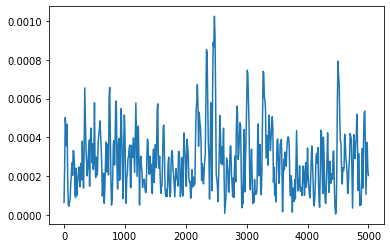

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000. 1010. 1020. 1030. 1040. 1050. 1060. 1070.
 1080. 1090. 1100. 1110. 1120. 1130. 1140. 1150. 1160. 1170. 1180. 1190.
 1200. 1210. 1220. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300. 1310.
 1320. 1330. 1340. 1350. 1360. 1370. 1380. 1390. 1400. 1410. 1420. 1430.
 1440. 1450. 1460. 1470. 1480. 1490. 1500. 1510. 1520. 1530. 1540. 1550.
 1560. 1570. 1580. 1590. 1600. 1610. 1620. 1630. 16

In [69]:
# see: https://www.analog.com/en/resources/technical-articles/use-python-for-analysis-of-noise.html
from scipy.signal import periodogram
fs,psd = periodogram(accy,10000,window='blackman',return_onesided=True)
vsd = np.sqrt(psd)
plt.plot(fs,vsd)
plt.show()
print(fs)

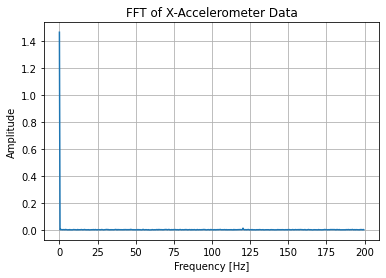

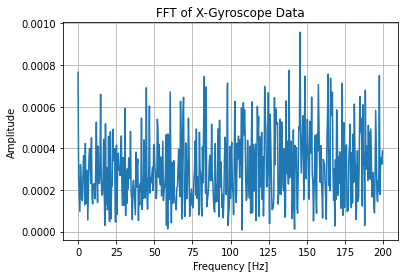

In [36]:
N = len(gx)  # Number of elements
# Compute FFTs
freqBins = np.linspace(0, fs_actual / 2, N // 2)  # Freq. labels [Hz]
# FFT of accelerometer data
fax = np.fft.fft(accx)  
fay = np.fft.fft(accy)
faz = np.fft.fft(accz)
# fgx = np.fft.fft(gx)  # FFT of gyro data

# Plot x-accel. FFT

plt.plot(freqBins[0:], (2 / N) * np.abs(fax[0:N // 2]))
# plt.plot(freqBins[1:], (2 / N) * np.abs(fax[1:N // 2]))
plt.title('FFT of X-Accelerometer Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()

# Plot x-gyro. FFT
plt.figure()
plt.plot(freqBins, (2 / N) * np.abs(fgx[:N // 2]))
plt.title('FFT of X-Gyroscope Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Now calculate the Allan variance. The module ``allan`` is not provided by ``pyplnoise``, but many similar codes can be found on pypi.

In [6]:
tau, avar, adev, error_adev_pct = allan.allan_variance(w, dt=1./fs, n_clusters=8000,
                                                       verbose=False)

In [7]:
# omit values with insufficient statistical quality
idx_valid = error_adev_pct < 10
avar_valid = avar[idx_valid]
adev_valid = adev[idx_valid]
tau_valid = tau[idx_valid]

Here's how the calculated Allan deviation looks like.

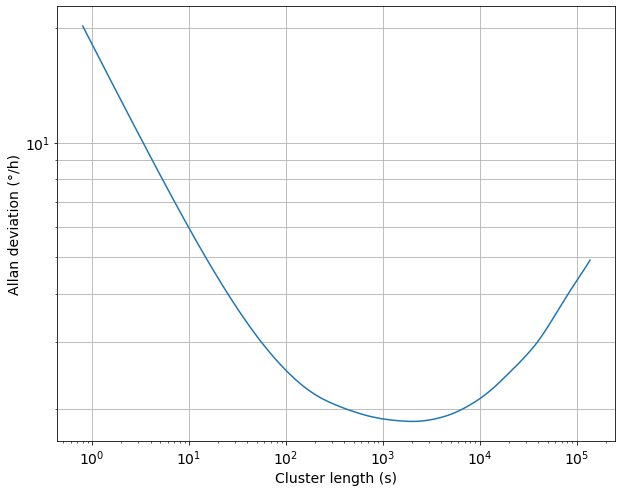

In [15]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid*3600)
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/h)")
ax.grid(True, which='major')
ax.grid(True, which='minor', axis='y')

Let's extract the properties $N$, $B$ and $K$ automatically:

In [9]:
noise_density, a_n_fit, b_n_fit = allan.read_noise_density(adev_valid, tau_valid)
print("Extracted angle random walk: N = {:.4g} °/s/sqrt(Hz) = {:.5f} °/sqrt(h)"
      .format(noise_density, noise_density*60))
bias_instability = allan.read_bias_instability(adev_valid, tau_valid)
print("Extracted bias instability: B = {:.4g} °/s = {:.5f} °/h"
      .format(bias_instability, bias_instability*3600))
rate_random_walk, a_k_fit, b_k_fit = allan.read_rate_random_walk(adev_valid, tau_valid)
print("Extracted rate random walk: K = {:.4g} °/s^(3/2) = {:.5f} °/h^(3/2)"
      .format(rate_random_walk, rate_random_walk*3600**(3/2)))

Extracted angle random walk: N = 0.005027 °/s/sqrt(Hz) = 0.30159 °/sqrt(h)
Extracted bias instability: B = 0.0007754 °/s = 2.79154 °/h
Extracted rate random walk: K = 6.792e-06 °/s^(3/2) = 1.46705 °/h^(3/2)


If you rather prefer to find these values manually, you can read off the value of the red line at $\tau = 1$ to get $N$. The value of the green line at $\tau = 3$ is equal to $K$, and multiplication of the global minimum by $\sqrt{\frac{\pi}{2\ln 2}}\approx1/0.664$ yields $B$.

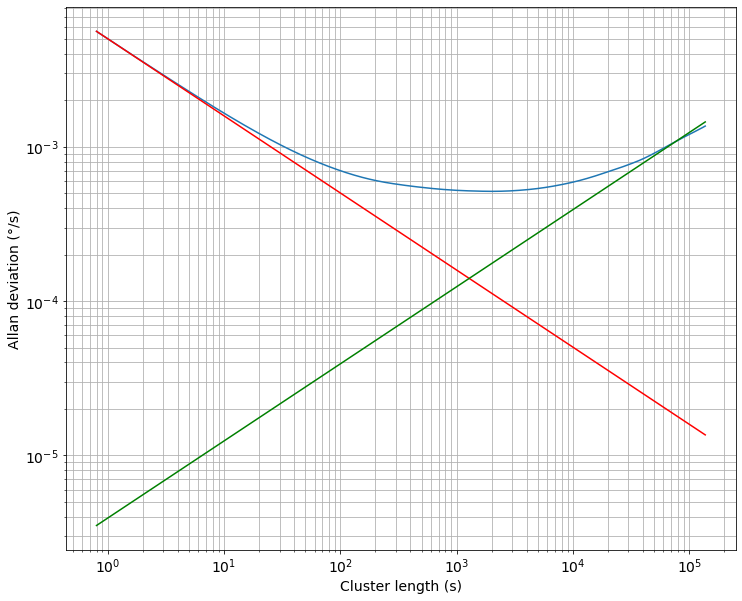

In [16]:
fit_vals_n = np.power(10.0, a_n_fit * np.log10(tau_valid) + b_n_fit)
fit_vals_k = np.power(10.0, a_k_fit * np.log10(tau_valid) + b_k_fit)
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid)
ax.loglog(tau_valid, fit_vals_n, color='red')
ax.loglog(tau_valid, fit_vals_k, color='green')
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/s)")
ax.grid(True, which='both')